# Comprehensive Acoustic Data Analysis
## Congo Aviary Bird Monitoring - Exploring the Data

**Analysis Journey:**
1. **Data Overview** - Understanding the full dataset and target species
2. **Audio Classification Analysis** - What types of sounds were recorded
3. **Model Performance** - How well did PERCH and BirdNET classify birds
4. **Temporal Patterns** - Activity patterns across time of day
5. **Nighttime Activity Investigation** - Investigating unusual nighttime detections
6. **Per-Night Activity Visualization** - Detailed nightly activity charts

**Target Species:**
- Black-headed weaver (*Ploceus melanocephalus*) - 5 individuals
- Eurasian hoopoe (*Upupa epops*) - 2 individuals
- Red-billed quelea (*Quelea quelea*) - 61 individuals

---
## Setup and Data Loading

In [46]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta
import warnings
warnings.filterwarnings('ignore')

# Enhanced visualization settings
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Paths
BASE_DIR = Path(r"c:\Users\Casper\Documents\GitHub\zoo-acoustics")
DATA_DIR = BASE_DIR / "data" / "fl_gaia_zoo_congo_15aug25_data"
FULL_DATA_FILE = DATA_DIR / "fl_gaia_zoo_congo_15aug25_data__fl_gaia_zoo_congo_15aug25_data_metadata_speechless_predictions.xlsx"
TARGET_DATA_FILE = DATA_DIR / "target_species_detections.xlsx"

# Target species mapping
SPECIES_INFO = {
    'Ploceus melanocephalus': {'common': 'Black-headed weaver', 'count': 5, 'color': '#FFB300'},
    'Upupa epops': {'common': 'Eurasian hoopoe', 'count': 2, 'color': '#E91E63'},
    'Quelea quelea': {'common': 'Red-billed quelea', 'count': 61, 'color': '#2196F3'}
}

In [47]:
# Load both datasets
df_full = pd.read_excel(FULL_DATA_FILE)
df_target = pd.read_excel(TARGET_DATA_FILE)

# Convert datetime columns
df_full['datetime'] = pd.to_datetime(df_full['datetime'])
df_target['datetime'] = pd.to_datetime(df_target['datetime'])

print(f"Full Dataset: {len(df_full):,} audio clips")
print(f"Target Species Dataset: {len(df_target):,} clips with target species")
print(f"Date Range: {df_full['datetime'].min().date()} to {df_full['datetime'].max().date()}")
print(f"Duration: {(df_full['datetime'].max() - df_full['datetime'].min()).days} days")

Full Dataset: 42,872 audio clips
Target Species Dataset: 12,495 clips with target species
Date Range: 2025-08-08 to 2025-08-15
Duration: 6 days


---
## Audio Classification Overview
### What types of sounds were captured?

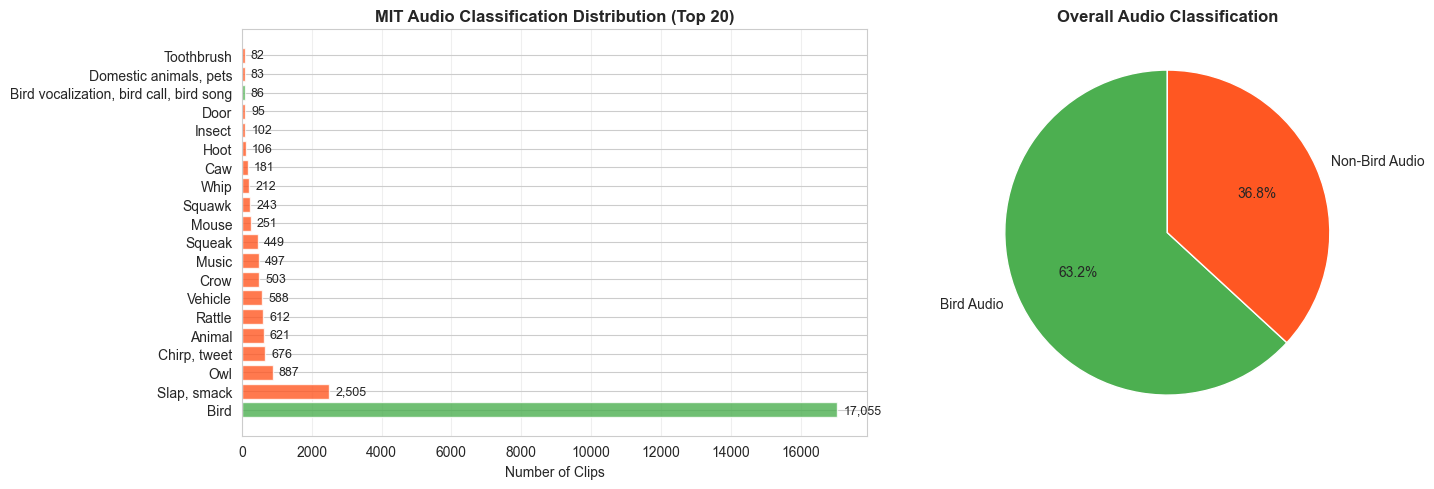

Bird audio clips: 17,145 (63.2%)
Non-bird audio clips: 10,002 (36.8%)


In [48]:
# Clean full dataset (remove invalid labels)
df_full_clean = df_full[~df_full['MIT_AST_label'].isin(['speech_removed', 'file_missing'])].copy()

# Classification distribution - top 20 only
mit_dist = df_full_clean['MIT_AST_label'].value_counts().head(20)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MIT Classification Distribution - Top 20
colors_mit = ['#4CAF50' if 'bird' in str(x).lower() else '#FF5722' for x in mit_dist.index]
axes[0].barh(range(len(mit_dist)), mit_dist.values, color=colors_mit, alpha=0.8)
axes[0].set_yticks(range(len(mit_dist)))
axes[0].set_yticklabels(mit_dist.index)
axes[0].set_xlabel('Number of Clips')
axes[0].set_title('MIT Audio Classification Distribution (Top 20)', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(mit_dist.values):
    axes[0].text(v + max(mit_dist.values)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Bird vs Non-Bird Pie Chart
bird_clips = df_full_clean['MIT_AST_label'].str.contains('bird', case=False, na=False).sum()
non_bird_clips = len(df_full_clean) - bird_clips

sizes = [bird_clips, non_bird_clips]
labels = ['Bird Audio', 'Non-Bird Audio']
colors = ['#4CAF50', '#FF5722']

axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Overall Audio Classification', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Bird audio clips: {bird_clips:,} ({bird_clips/len(df_full_clean)*100:.1f}%)")
print(f"Non-bird audio clips: {non_bird_clips:,} ({non_bird_clips/len(df_full_clean)*100:.1f}%)")

### Target Species Detections
How many bird classifications do we have from target species compared to total audio clips?

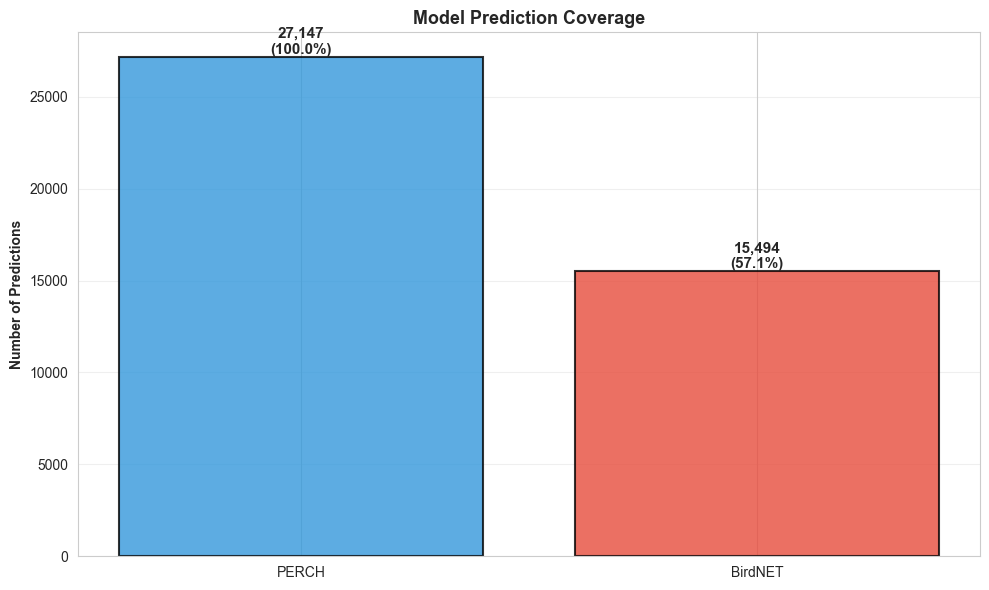

In [49]:
# Count predictions from each model
perch_predictions = df_full_clean['perch_prediction'].notna().sum()
birdnet_predictions = df_full_clean['birdnet_prediction'].notna().sum()

# Create comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['PERCH', 'BirdNET']
predictions = [perch_predictions, birdnet_predictions]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(models, predictions, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Predictions', fontweight='bold')
ax.set_title('Model Prediction Coverage', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, predictions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:,}\n({val/len(df_full_clean)*100:.1f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

In [50]:
# Compare target species detections with total clips
print(f"Total audio clips in full dataset: {len(df_full_clean):,}")
print(f"Target species detections: {len(df_target):,} ({len(df_target)/len(df_full_clean)*100:.2f}%)")
print(f"\nTarget species breakdown:")
for species in df_target['detected_species'].unique():
    count = len(df_target[df_target['detected_species'] == species])
    print(f"  {SPECIES_INFO[species]['common']}: {count:,} detections")

Total audio clips in full dataset: 27,147
Target species detections: 12,495 (46.03%)

Target species breakdown:
  Red-billed quelea: 5,556 detections
  Black-headed weaver: 6,876 detections
  Eurasian hoopoe: 63 detections


---
## Model Performance Analysis
### How well did the models perform?

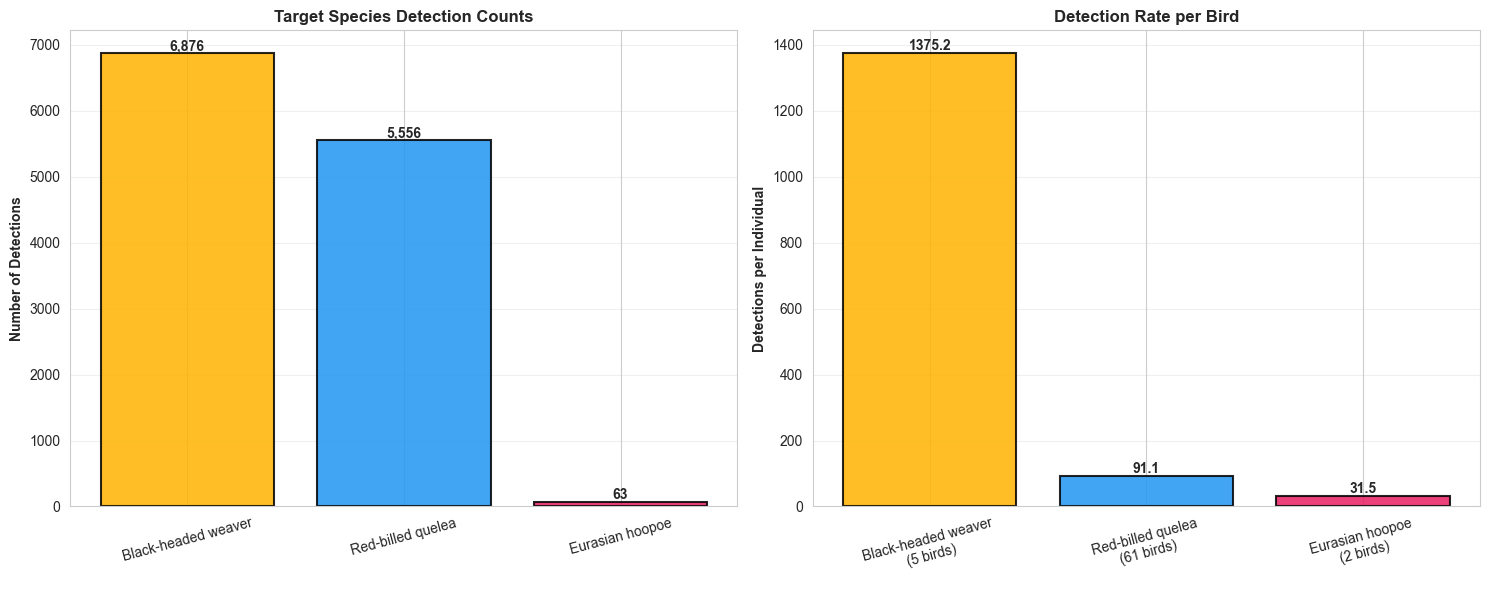

In [51]:
# Species detection counts
species_counts = df_target['detected_species'].value_counts()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Detection counts by species
species_names = [SPECIES_INFO[sp]['common'] for sp in species_counts.index]
colors = [SPECIES_INFO[sp]['color'] for sp in species_counts.index]

bars = axes[0].bar(species_names, species_counts.values, color=colors, alpha=0.85, 
                   edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Detections', fontweight='bold')
axes[0].set_title('Target Species Detection Counts', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, species_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
               f'{val:,}', ha='center', va='bottom', fontweight='bold')

# Detections per individual bird
detections_per_bird = []
species_labels = []
for sp in species_counts.index:
    count = species_counts[sp]
    individuals = SPECIES_INFO[sp]['count']
    per_bird = count / individuals
    detections_per_bird.append(per_bird)
    species_labels.append(f"{SPECIES_INFO[sp]['common']}\n({individuals} birds)")

bars = axes[1].bar(species_labels, detections_per_bird, color=colors, alpha=0.85,
                  edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Detections per Individual', fontweight='bold')
axes[1].set_title('Detection Rate per Bird', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, detections_per_bird):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Model Agreement Analysis
Which model predicted which species, and how often did they agree?

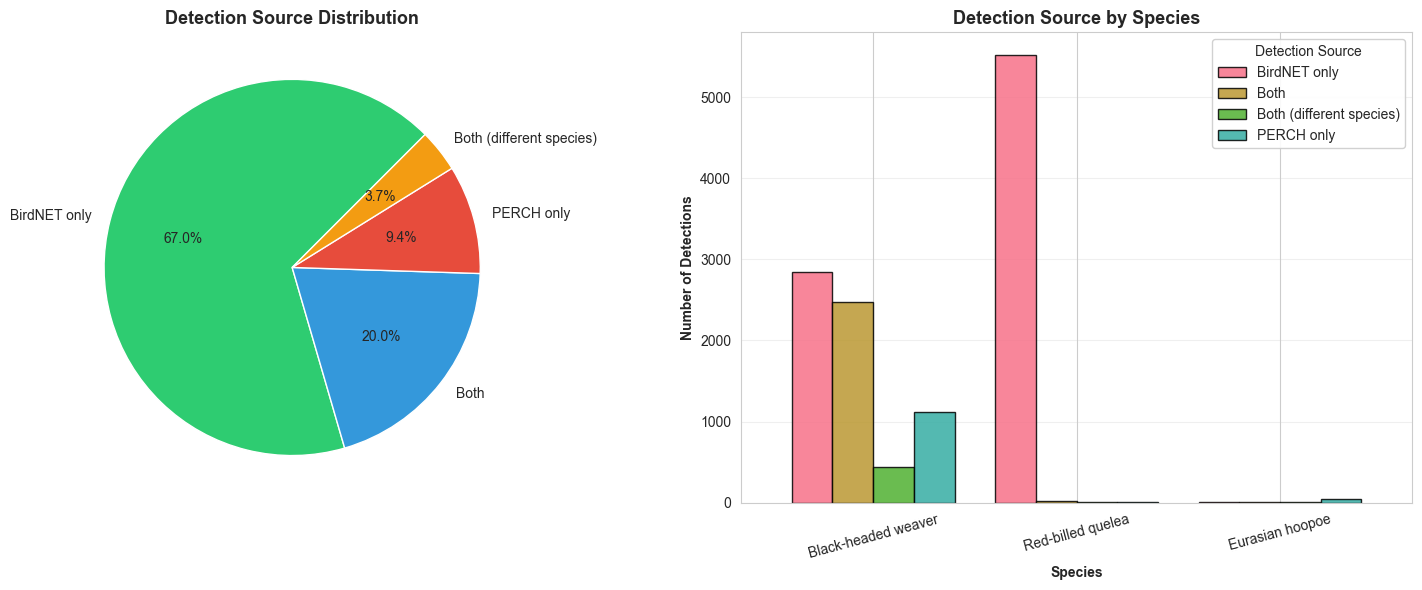

Model agreement rate: 20.0% (2,497 of 12,495 detections)


In [52]:
# Detection source analysis
detection_sources = df_target['detection_source'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Overall detection source pie chart
colors_source = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

axes[0].pie(detection_sources.values, labels=detection_sources.index, colors=colors_source,
           autopct='%1.1f%%', startangle=45)
axes[0].set_title('Detection Source Distribution', fontweight='bold', fontsize=13)

# Detection source by species
source_species = df_target.groupby(['detected_species', 'detection_source']).size().unstack(fill_value=0)
source_species.index = [SPECIES_INFO[idx]['common'] for idx in source_species.index]

source_species.plot(kind='bar', ax=axes[1], width=0.8, alpha=0.85, 
                   edgecolor='black', linewidth=1, stacked=False)
axes[1].set_xlabel('Species', fontweight='bold')
axes[1].set_ylabel('Number of Detections', fontweight='bold')
axes[1].set_title('Detection Source by Species', fontweight='bold', fontsize=13)
axes[1].legend(title='Detection Source', framealpha=0.9, loc='upper right')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate agreement rate
both_detections = detection_sources.get('Both', 0)
agreement_rate = (both_detections / len(df_target)) * 100
print(f"Model agreement rate: {agreement_rate:.1f}% ({both_detections:,} of {len(df_target):,} detections)")

---
## Temporal Analysis
### Activity patterns across time

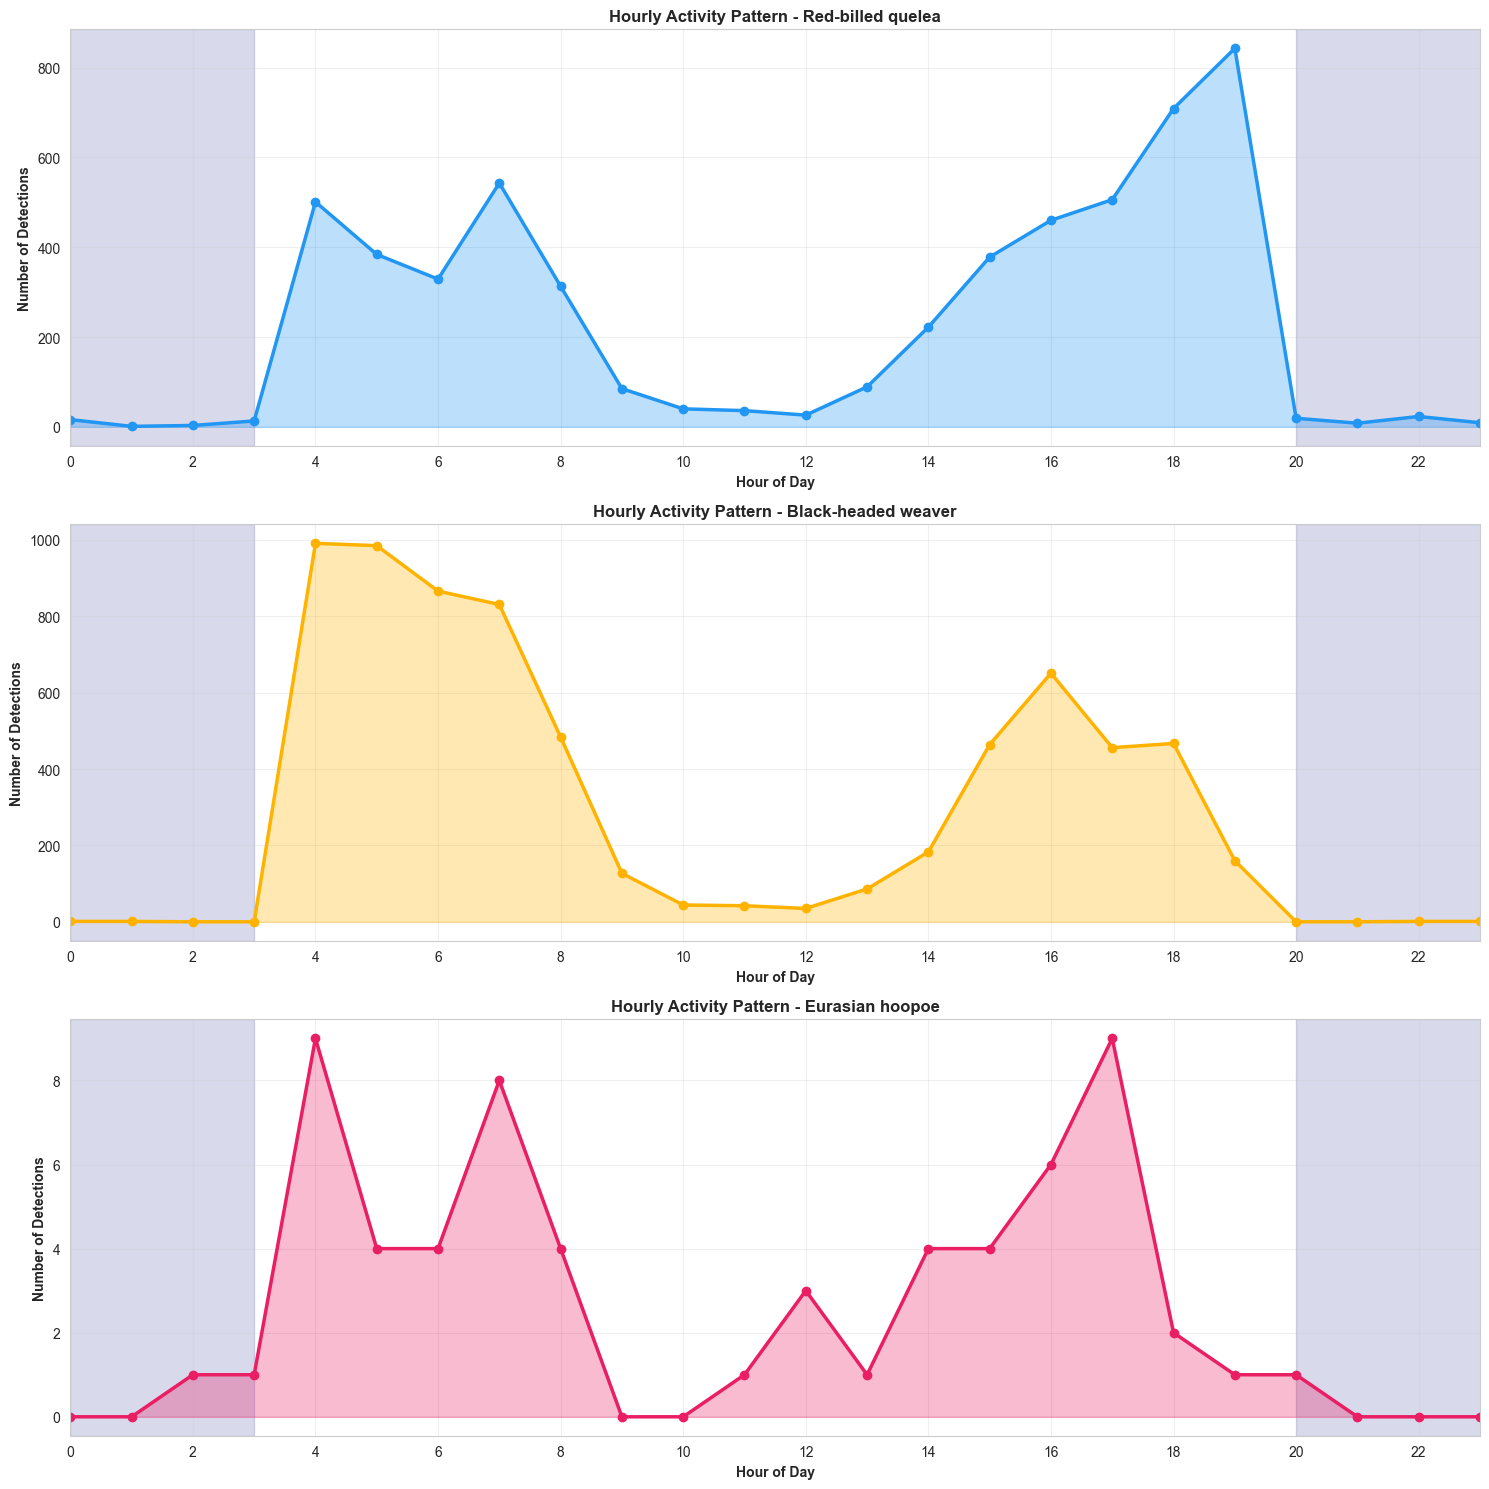

In [53]:
# Extract temporal features
df_target['hour'] = df_target['datetime'].dt.hour
df_target['date'] = df_target['datetime'].dt.date
df_target['day_of_week'] = df_target['datetime'].dt.day_name()
df_target['time_of_day'] = df_target['hour'].apply(lambda x: 
    'Night (0-6h)' if x < 6 else
    'Morning (6-12h)' if x < 12 else
    'Afternoon (12-18h)' if x < 18 else
    'Evening (18-24h)'
)

# Hourly activity patterns - separate plots for each species
species_list = df_target['detected_species'].unique()
n_species = len(species_list)

fig, axes = plt.subplots(n_species, 1, figsize=(15, 5 * n_species))
if n_species == 1:
    axes = [axes]

for idx, species in enumerate(species_list):
    species_data = df_target[df_target['detected_species'] == species]
    hourly_counts = species_data['hour'].value_counts().sort_index()
    
    # Ensure all hours are represented
    all_hours = pd.Series(0, index=range(24))
    all_hours.update(hourly_counts)
    
    axes[idx].plot(all_hours.index, all_hours.values, marker='o', linewidth=2.5,
                  color=SPECIES_INFO[species]['color'], markersize=6)
    axes[idx].fill_between(all_hours.index, all_hours.values, alpha=0.3, 
                           color=SPECIES_INFO[species]['color'])
    
    axes[idx].set_xlabel('Hour of Day', fontweight='bold')
    axes[idx].set_ylabel('Number of Detections', fontweight='bold')
    axes[idx].set_title(f'Hourly Activity Pattern - {SPECIES_INFO[species]["common"]}', 
                       fontweight='bold', fontsize=12)
    axes[idx].set_xticks(range(0, 24, 2))
    axes[idx].set_xlim(0, 23)
    axes[idx].grid(alpha=0.3)

    # Add nighttime background (8 PM to 3 AM: hours 20-23 and 0-2)
    axes[idx].axvspan(20, 24, alpha=0.15, color='navy', zorder=0)
    axes[idx].axvspan(0, 3, alpha=0.15, color='navy', zorder=0)

plt.tight_layout()
plt.show()


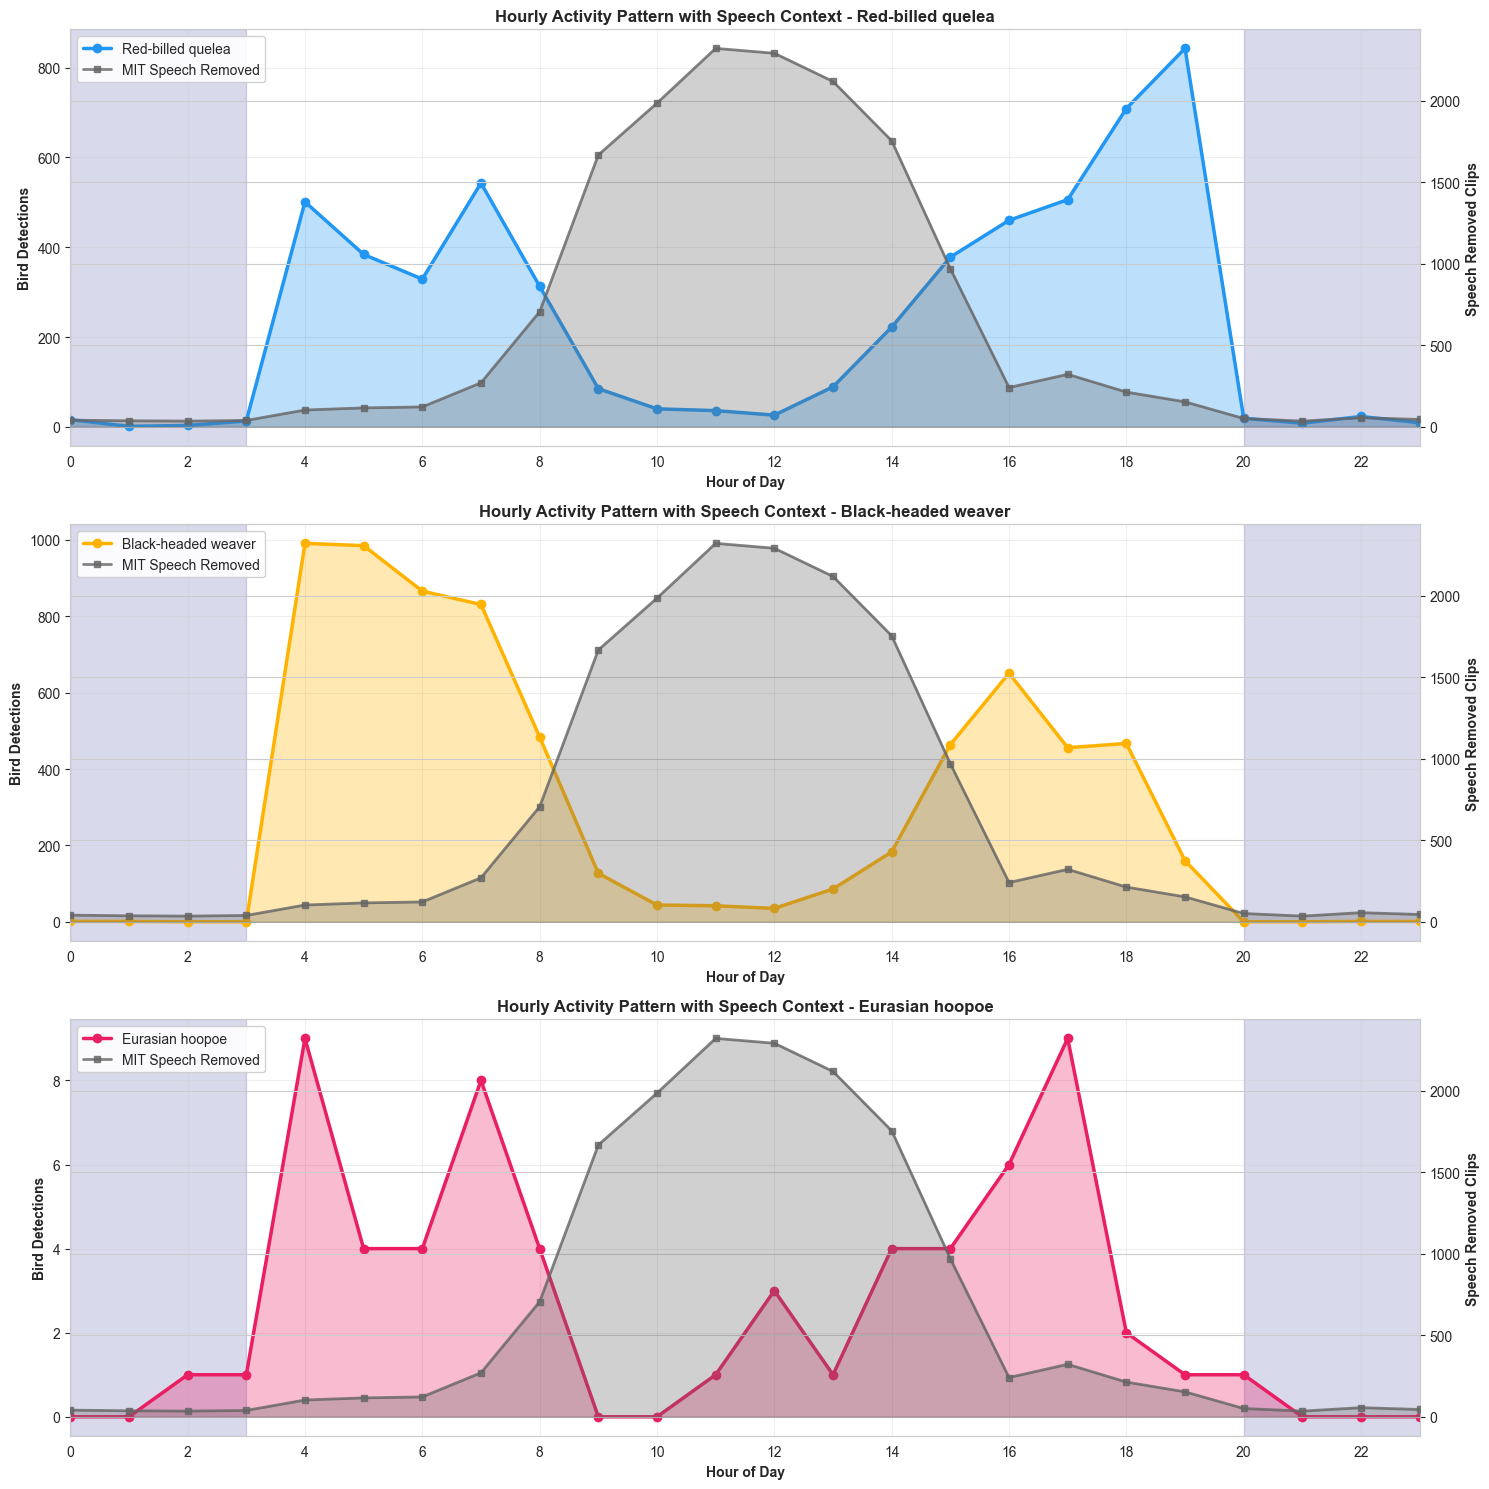

In [54]:
# Hourly activity patterns with MIT speech_removed overlay
# Get speech_removed hourly counts from full dataset
speech_removed_data = df_full[df_full['MIT_AST_label'] == 'speech_removed'].copy()
speech_removed_data['hour'] = speech_removed_data['datetime'].dt.hour
speech_removed_hourly = speech_removed_data['hour'].value_counts().sort_index()

# Ensure all hours are represented for speech_removed
speech_removed_all_hours = pd.Series(0, index=range(24))
speech_removed_all_hours.update(speech_removed_hourly)

species_list = df_target['detected_species'].unique()
n_species = len(species_list)

fig, axes = plt.subplots(n_species, 1, figsize=(15, 5 * n_species))
if n_species == 1:
    axes = [axes]

for idx, species in enumerate(species_list):
    species_data = df_target[df_target['detected_species'] == species]
    hourly_counts = species_data['hour'].value_counts().sort_index()
    
    # Ensure all hours are represented
    all_hours = pd.Series(0, index=range(24))
    all_hours.update(hourly_counts)
    
    # Create twin axis for speech_removed
    ax2 = axes[idx].twinx()
    
    # Add nighttime background (8 PM to 3 AM: hours 20-23 and 0-2)
    axes[idx].axvspan(20, 24, alpha=0.15, color='navy', zorder=0)
    axes[idx].axvspan(0, 3, alpha=0.15, color='navy', zorder=0)
    
    # Plot bird species on primary axis (behind speech_removed)
    axes[idx].plot(all_hours.index, all_hours.values, marker='o', linewidth=2.5,
                  color=SPECIES_INFO[species]['color'], markersize=6, label=SPECIES_INFO[species]['common'], zorder=2)
    axes[idx].fill_between(all_hours.index, all_hours.values, alpha=0.3, 
                           color=SPECIES_INFO[species]['color'], zorder=2)
    
    # Plot speech_removed on secondary axis (grey solid line with fill, in front)
    ax2.plot(speech_removed_all_hours.index, speech_removed_all_hours.values, 
             marker='s', linewidth=2, color='#666666', markersize=4, 
             linestyle='-', alpha=0.8, label='MIT Speech Removed', zorder=3)
    ax2.fill_between(speech_removed_all_hours.index, speech_removed_all_hours.values, 
                     alpha=0.3, color='#666666', zorder=3)
    
    axes[idx].set_xlabel('Hour of Day', fontweight='bold')
    axes[idx].set_ylabel('Bird Detections', fontweight='bold')
    ax2.set_ylabel('Speech Removed Clips', fontweight='bold')
    axes[idx].set_title(f'Hourly Activity Pattern with Speech Context - {SPECIES_INFO[species]["common"]}', 
                       fontweight='bold', fontsize=12)
    axes[idx].set_xticks(range(0, 24, 2))
    axes[idx].set_xlim(0, 23)
    axes[idx].grid(alpha=0.3)
    
    # Add combined legend
    lines1, labels1 = axes[idx].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[idx].legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.9)

plt.tight_layout()
plt.show()


---
## Nighttime Activity Investigation
### Exploring unusual nighttime detections (8 PM - 3 AM)

Total nighttime detections: 85 (0.68% of all detections)

Nighttime detections by species:
  Red-billed quelea: 79 (1.42% of species total)
  Black-headed weaver: 4 (0.06% of species total)
  Eurasian hoopoe: 2 (3.17% of species total)


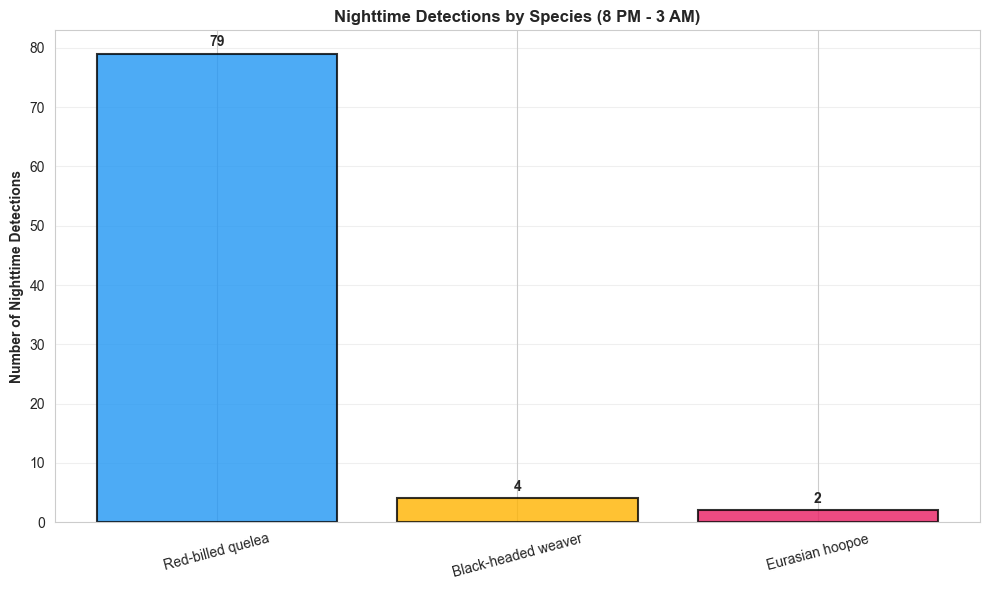

In [55]:
# Define nighttime window: 20:00 (8 PM) to 03:00 (3 AM)
# Note: Hour 20, 21, 22, 23, 0, 1, 2
nighttime_hours = [20, 21, 22, 23, 0, 1, 2]

# Filter target detections for nighttime
df_night = df_target[df_target['hour'].isin(nighttime_hours)].copy()

print(f"Total nighttime detections: {len(df_night)} ({len(df_night)/len(df_target)*100:.2f}% of all detections)")
print(f"\nNighttime detections by species:")
for species in df_target['detected_species'].unique():
    night_count = len(df_night[df_night['detected_species'] == species])
    total_count = len(df_target[df_target['detected_species'] == species])
    print(f"  {SPECIES_INFO[species]['common']}: {night_count} ({night_count/total_count*100:.2f}% of species total)")

# Visualize nighttime detections by species
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Nighttime detections only
species_names = []
night_counts = []
colors = []

for species in df_target['detected_species'].unique():
    night_count = len(df_night[df_night['detected_species'] == species])
    species_names.append(SPECIES_INFO[species]['common'])
    night_counts.append(night_count)
    colors.append(SPECIES_INFO[species]['color'])

ax.bar(species_names, night_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Nighttime Detections', fontweight='bold')
ax.set_title('Nighttime Detections by Species (8 PM - 3 AM)', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=15)

# Add value labels
for i, v in enumerate(night_counts):
    ax.text(i, v + max(night_counts)*0.01, f'{v}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Context Analysis: 5-Minute Window Around Nighttime Detections
Examining the acoustic context before and after nighttime bird detections

Clips analyzed in 5-minute windows:
  Before detections: 566
  After detections: 405

Most common sounds before nighttime detections:
Fireworks         140
speech_removed     81
Slap, smack        74
Bird               65
Explosion          41
Rattle             25
Vehicle            24
Music              16
Animal             13
Toothbrush         12
Name: count, dtype: int64

Most common sounds after nighttime detections:
Slap, smack       70
speech_removed    59
Bird              58
Fireworks         47
Vehicle           29
Explosion         24
Rattle            16
Music             12
Toothbrush        12
Animal             8
Name: count, dtype: int64


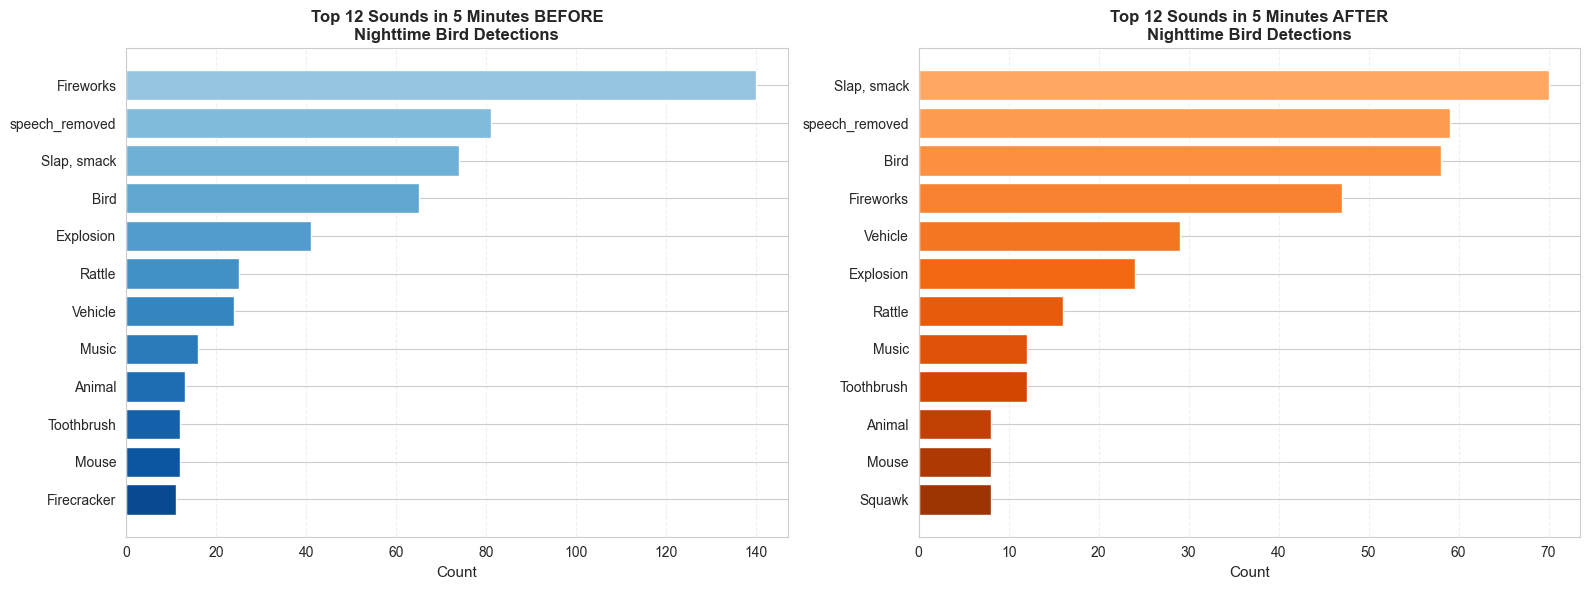

In [56]:
# Analyze context around nighttime detections
df_full_clean = df_full.dropna(subset=['datetime'])

# 5-minute window analysis
window_5min = timedelta(minutes=5)

before_labels_all = []
after_labels_all = []

for idx, night_clip in df_night.iterrows():
    clip_time = night_clip['datetime']
    
    # Get clips 5 minutes before and after
    clips_before = df_full_clean[
        (df_full_clean['datetime'] >= clip_time - window_5min) & 
        (df_full_clean['datetime'] < clip_time)
    ]
    clips_after = df_full_clean[
        (df_full_clean['datetime'] > clip_time) & 
        (df_full_clean['datetime'] <= clip_time + window_5min)
    ]
    
    # Collect MIT classifications
    before_mit = clips_before['MIT_AST_label'].dropna().tolist()
    after_mit = clips_after['MIT_AST_label'].dropna().tolist()
    
    before_labels_all.extend(before_mit)
    after_labels_all.extend(after_mit)

# Count frequencies
before_counts = pd.Series(before_labels_all).value_counts()
after_counts = pd.Series(after_labels_all).value_counts()

print(f"Clips analyzed in 5-minute windows:")
print(f"  Before detections: {len(before_labels_all)}")
print(f"  After detections: {len(after_labels_all)}")
print(f"\nMost common sounds before nighttime detections:")
print(before_counts.head(10))
print(f"\nMost common sounds after nighttime detections:")
print(after_counts.head(10))

# Visualize the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 12 sounds before nighttime detections
top_before = before_counts.head(12)
colors_before = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_before)))

ax1.barh(range(len(top_before)), top_before.values, color=colors_before)
ax1.set_yticks(range(len(top_before)))
ax1.set_yticklabels(top_before.index, fontsize=10)
ax1.set_xlabel('Count', fontsize=11)
ax1.set_title('Top 12 Sounds in 5 Minutes BEFORE\nNighttime Bird Detections', 
              fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Top 12 sounds after nighttime detections
top_after = after_counts.head(12)
colors_after = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_after)))

ax2.barh(range(len(top_after)), top_after.values, color=colors_after)
ax2.set_yticks(range(len(top_after)))
ax2.set_yticklabels(top_after.index, fontsize=10)
ax2.set_xlabel('Count', fontsize=11)
ax2.set_title('Top 12 Sounds in 5 Minutes AFTER\nNighttime Bird Detections', 
              fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [57]:
# Identify nights with bird activity during nighttime hours (8 PM - 3 AM)
nighttime_hours = [20, 21, 22, 23, 0, 1, 2]

# Add date column to df_night for grouping
df_night['night_date'] = df_night['datetime'].apply(lambda x: 
    x.date() if x.hour >= 20 else (x - timedelta(days=1)).date()
)

# Get unique nights with bird detections
nights_with_birds = df_night['night_date'].unique()
nights_with_birds = sorted(nights_with_birds)

print(f"Nights with bird detections: {len(nights_with_birds)}")
print(f"\nDetections per night:")
for night in nights_with_birds:
    night_detections = df_night[df_night['night_date'] == night]
    print(f"  {night}: {len(night_detections)} detections")
    for species in night_detections['detected_species'].unique():
        count = len(night_detections[night_detections['detected_species'] == species])
        print(f"    {SPECIES_INFO[species]['common']}: {count}")

Nights with bird detections: 6

Detections per night:
  2025-08-09: 8 detections
    Red-billed quelea: 8
  2025-08-10: 11 detections
    Eurasian hoopoe: 2
    Red-billed quelea: 9
  2025-08-11: 17 detections
    Red-billed quelea: 15
    Black-headed weaver: 2
  2025-08-12: 23 detections
    Red-billed quelea: 23
  2025-08-13: 22 detections
    Red-billed quelea: 21
    Black-headed weaver: 1
  2025-08-14: 4 detections
    Red-billed quelea: 3
    Black-headed weaver: 1


---
## Per-Night Activity Visualization
### Detailed activity charts for each night with bird detections


Night: 2025-08-09


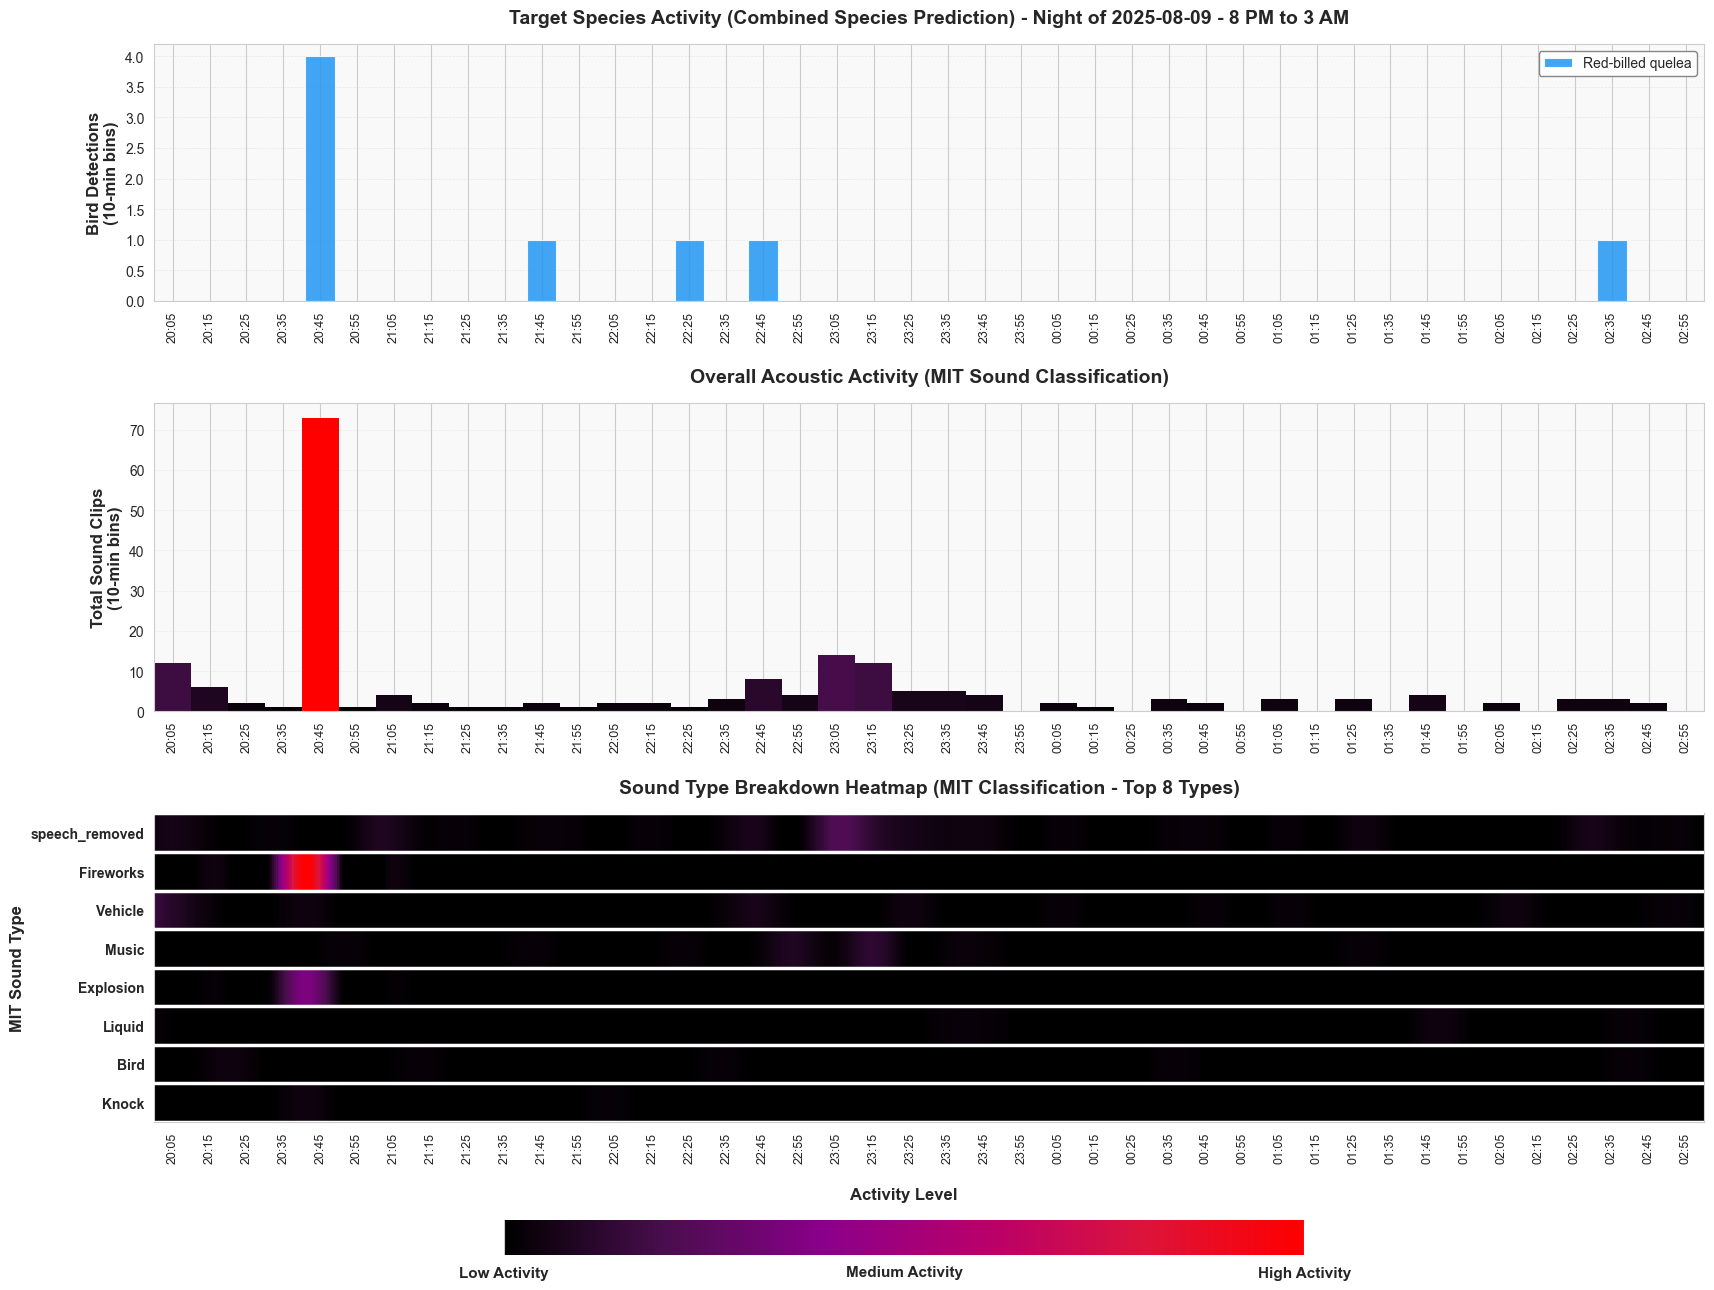

  Total bird detections: 8
  Total sound clips: 194
  Peak bird activity hour: 20:00
  Top 5 sound types:
    1. speech_removed: 52 clips (26.8%)
    2. Fireworks: 47 clips (24.2%)
    3. Vehicle: 24 clips (12.4%)
    4. Music: 18 clips (9.3%)
    5. Explosion: 17 clips (8.8%)
  Species breakdown:
    Red-billed quelea: 8 detections (100.0%)

Night: 2025-08-10


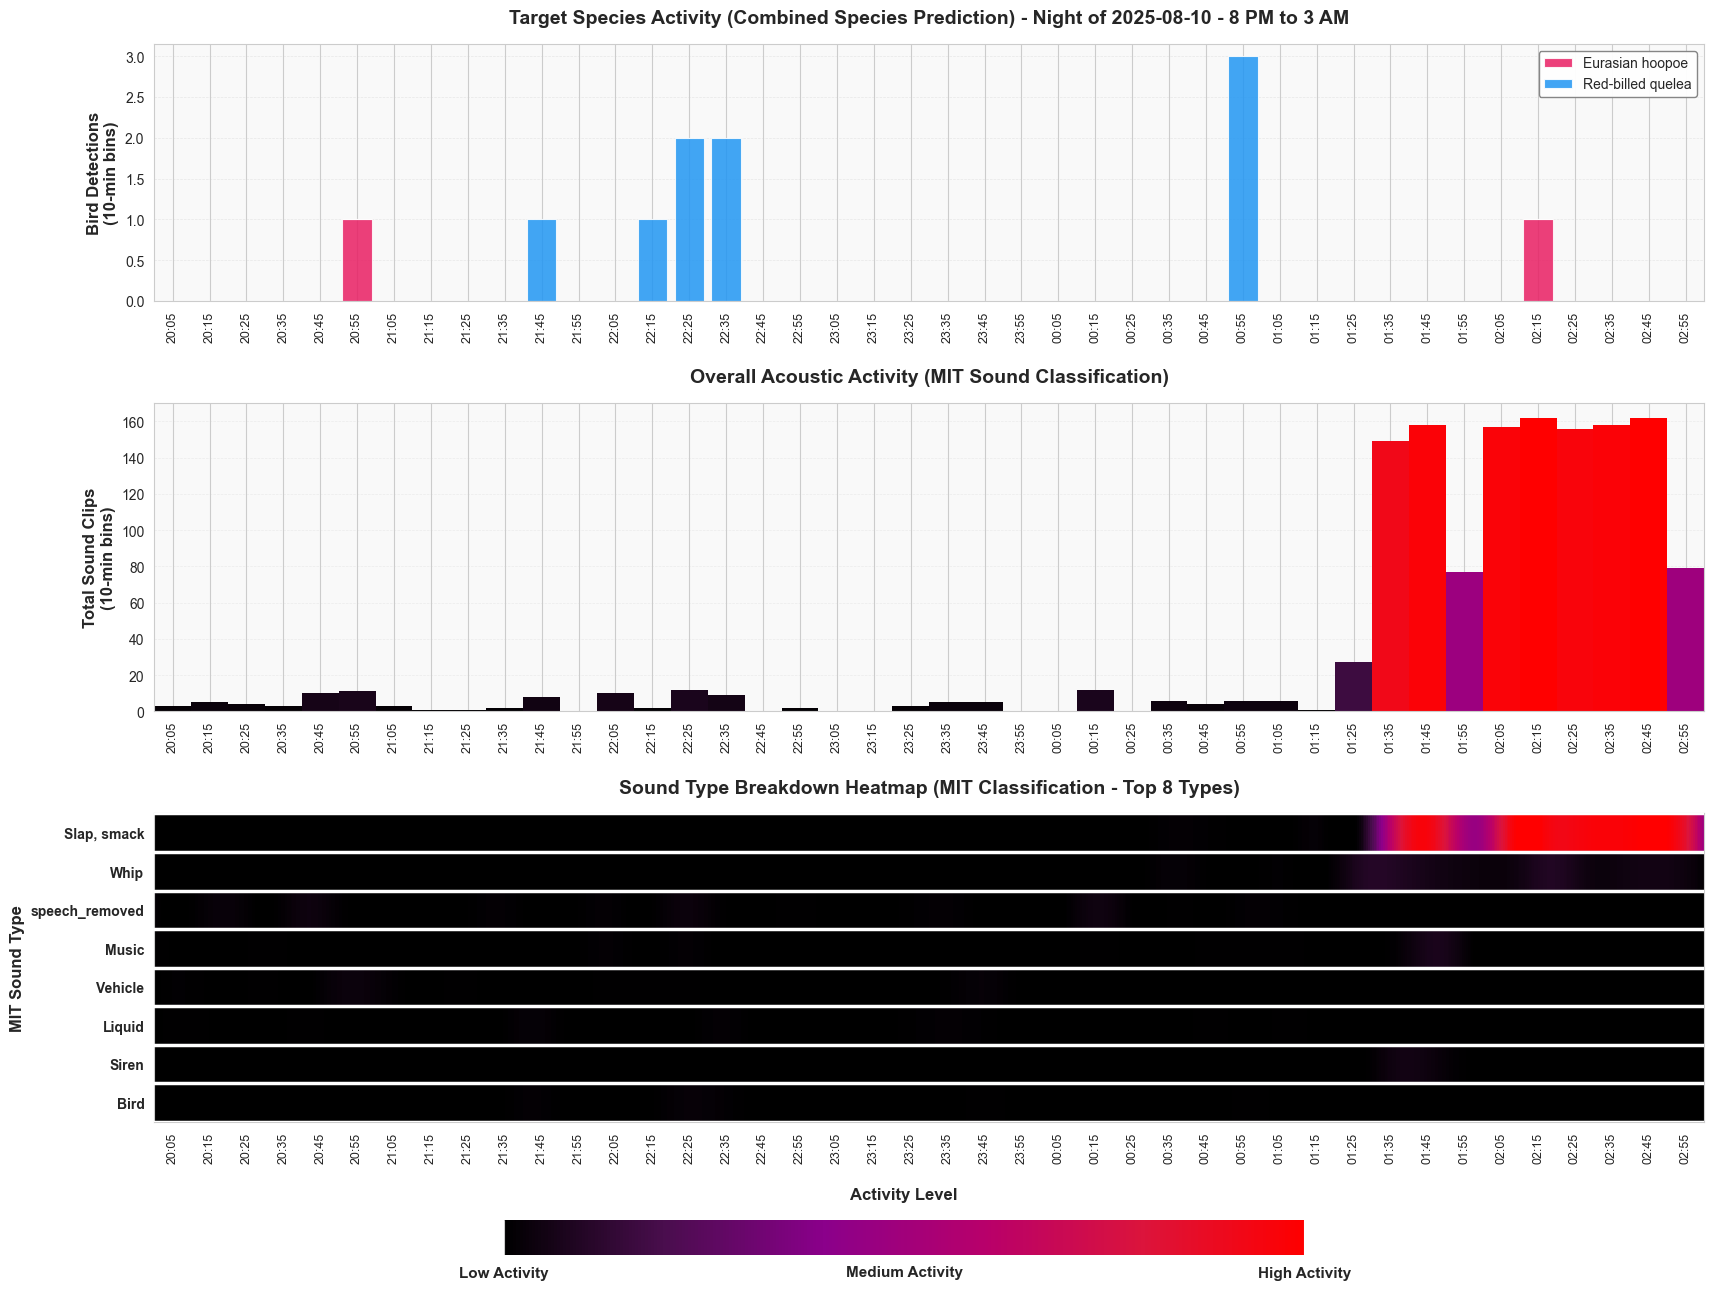

  Total bird detections: 11
  Total sound clips: 1419
  Peak bird activity hour: 22:00
  Top 5 sound types:
    1. Slap, smack: 1169 clips (82.4%)
    2. Whip: 87 clips (6.1%)
    3. speech_removed: 39 clips (2.7%)
    4. Music: 24 clips (1.7%)
    5. Vehicle: 18 clips (1.3%)
  Species breakdown:
    Eurasian hoopoe: 2 detections (18.2%)
    Red-billed quelea: 9 detections (81.8%)

Night: 2025-08-11


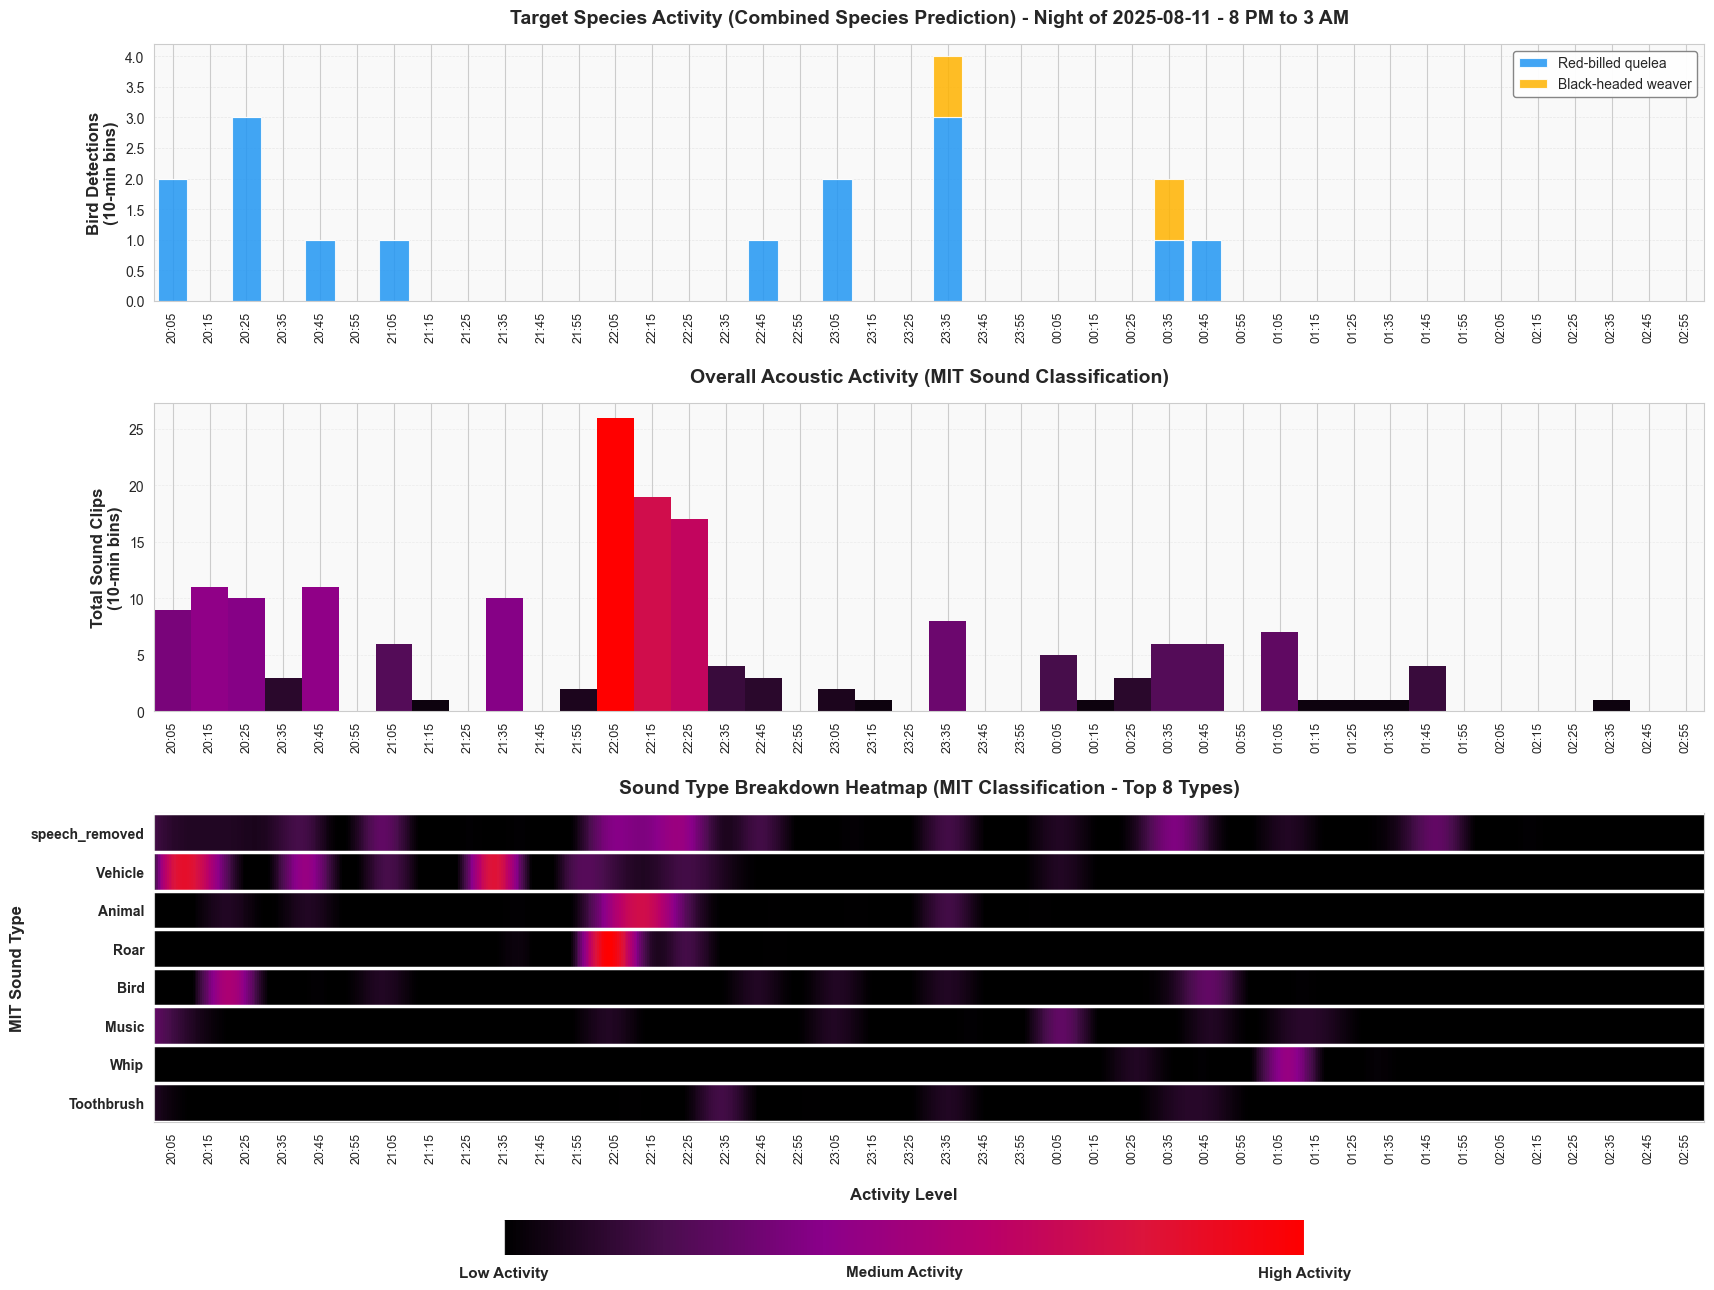

  Total bird detections: 17
  Total sound clips: 179
  Peak bird activity hour: 20:00
  Top 5 sound types:
    1. speech_removed: 40 clips (22.3%)
    2. Vehicle: 38 clips (21.2%)
    3. Animal: 20 clips (11.2%)
    4. Roar: 15 clips (8.4%)
    5. Bird: 14 clips (7.8%)
  Species breakdown:
    Red-billed quelea: 15 detections (88.2%)
    Black-headed weaver: 2 detections (11.8%)

Night: 2025-08-12


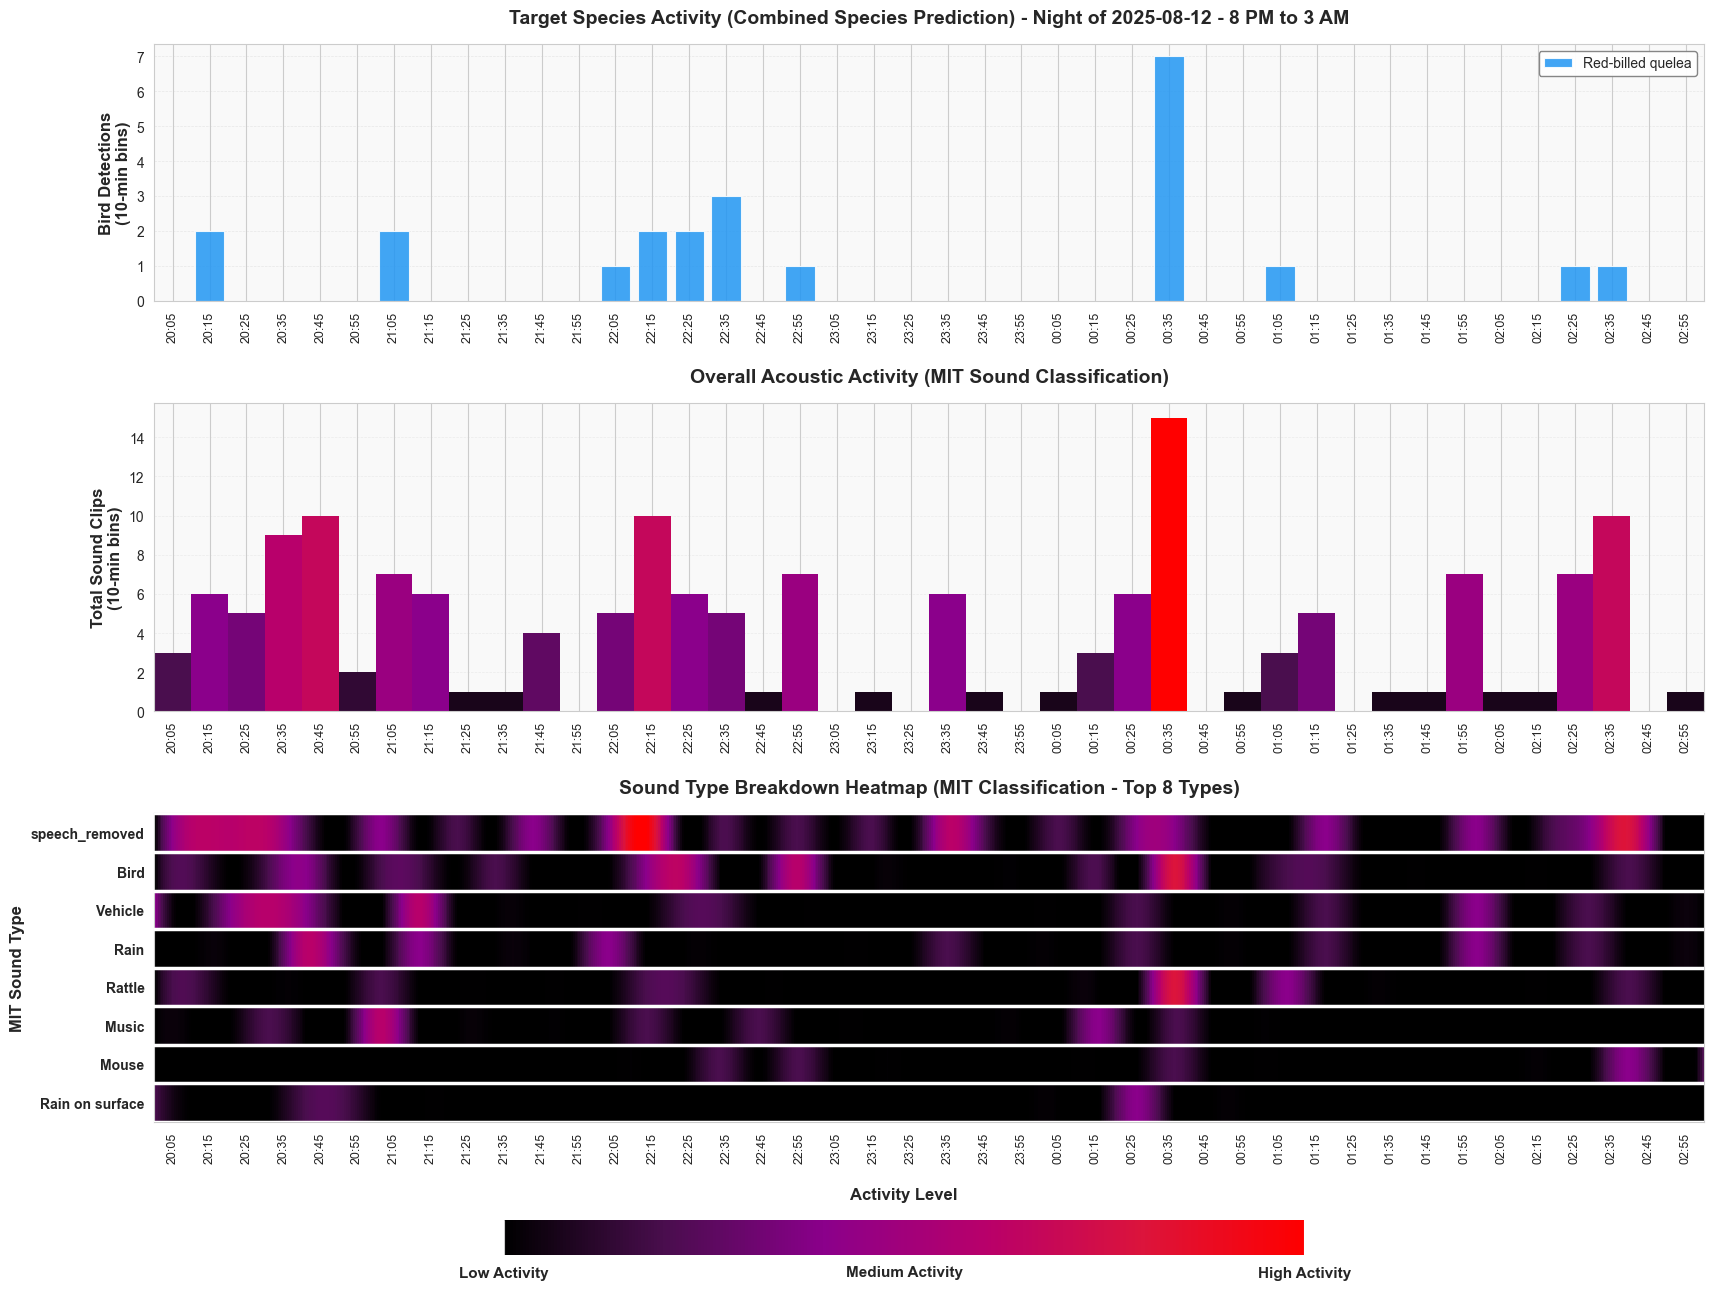

  Total bird detections: 23
  Total sound clips: 159
  Peak bird activity hour: 22:00
  Top 5 sound types:
    1. speech_removed: 45 clips (28.3%)
    2. Bird: 23 clips (14.5%)
    3. Vehicle: 19 clips (11.9%)
    4. Rain: 14 clips (8.8%)
    5. Rattle: 11 clips (6.9%)
  Species breakdown:
    Red-billed quelea: 23 detections (100.0%)

Night: 2025-08-13


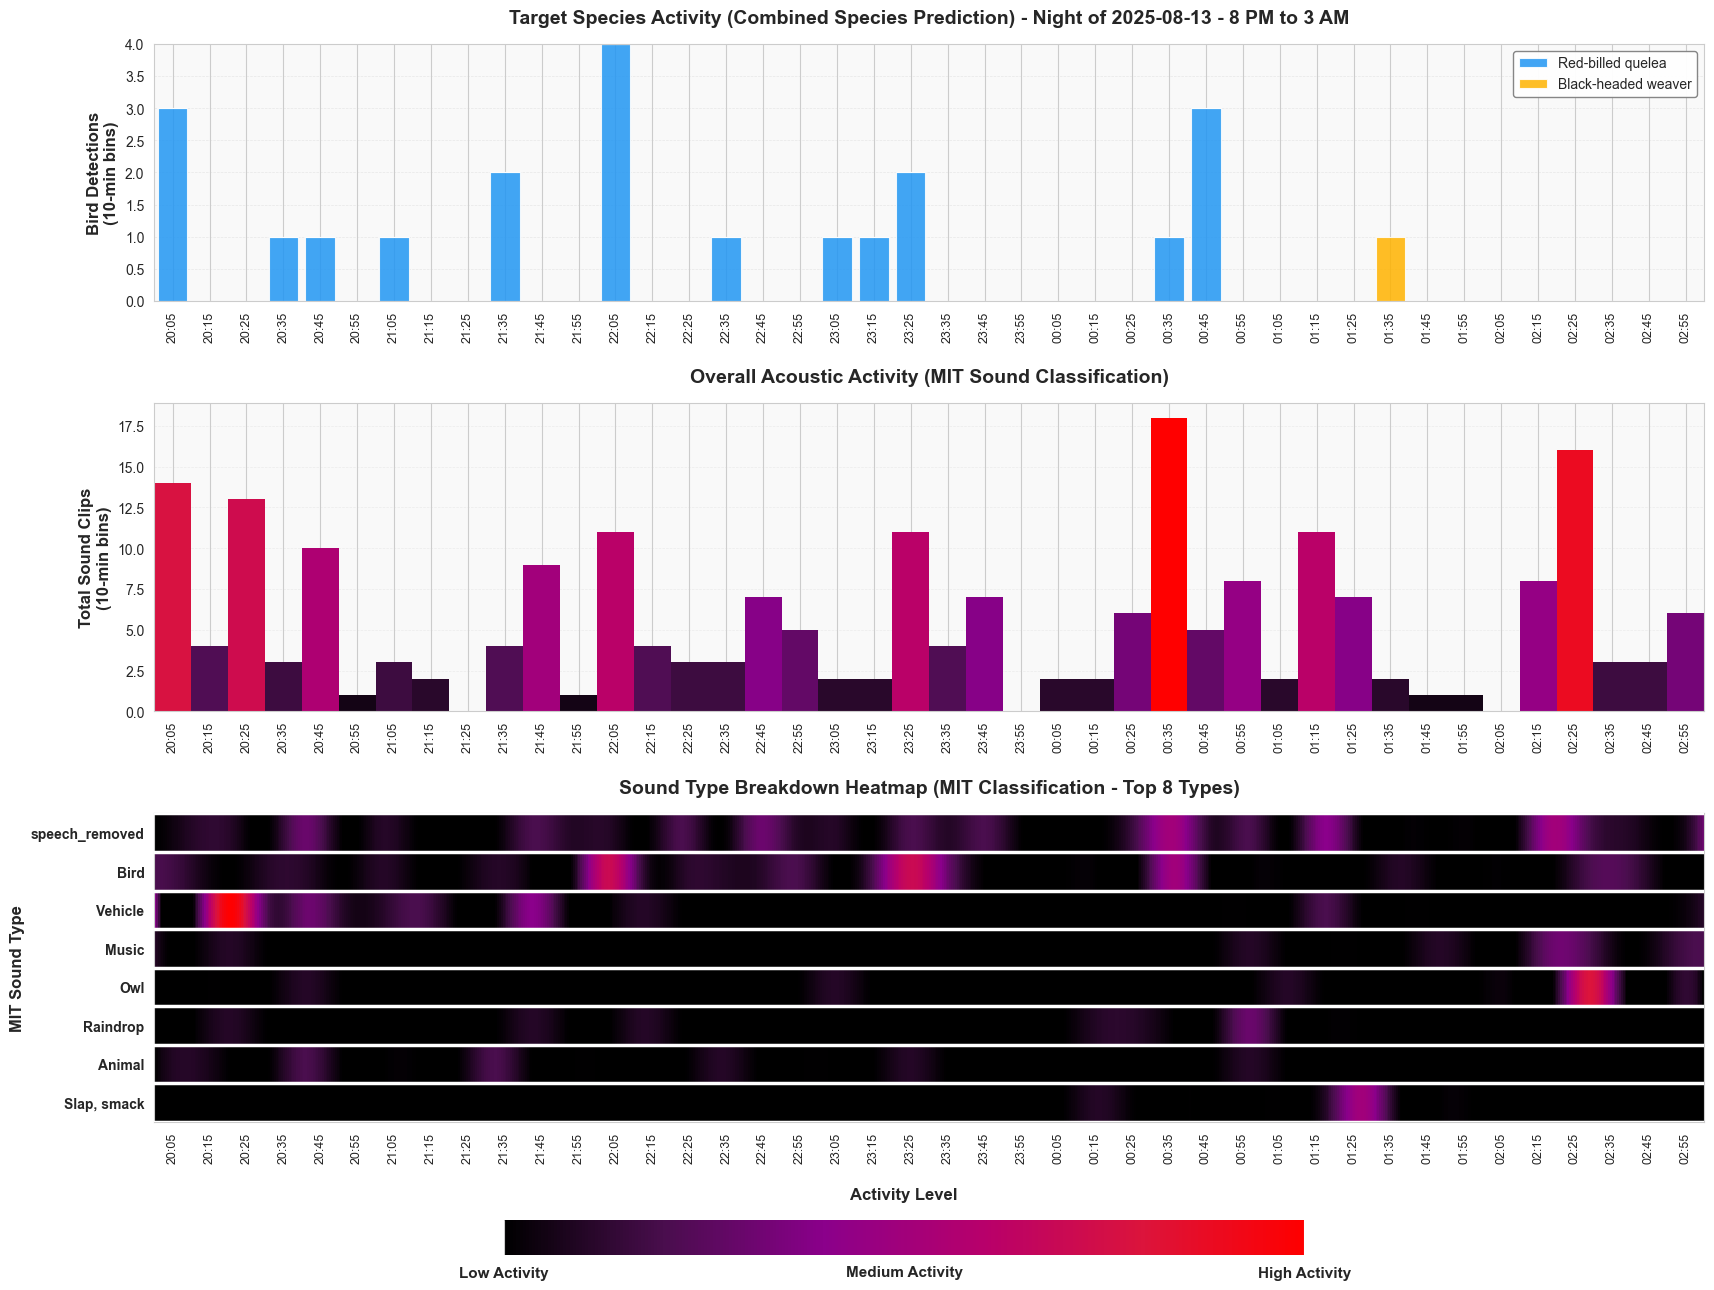

  Total bird detections: 22
  Total sound clips: 224
  Peak bird activity hour: 20:00
  Top 5 sound types:
    1. speech_removed: 47 clips (21.0%)
    2. Bird: 42 clips (18.8%)
    3. Vehicle: 31 clips (13.8%)
    4. Music: 12 clips (5.4%)
    5. Owl: 11 clips (4.9%)
  Species breakdown:
    Red-billed quelea: 21 detections (95.5%)
    Black-headed weaver: 1 detections (4.5%)

Night: 2025-08-14


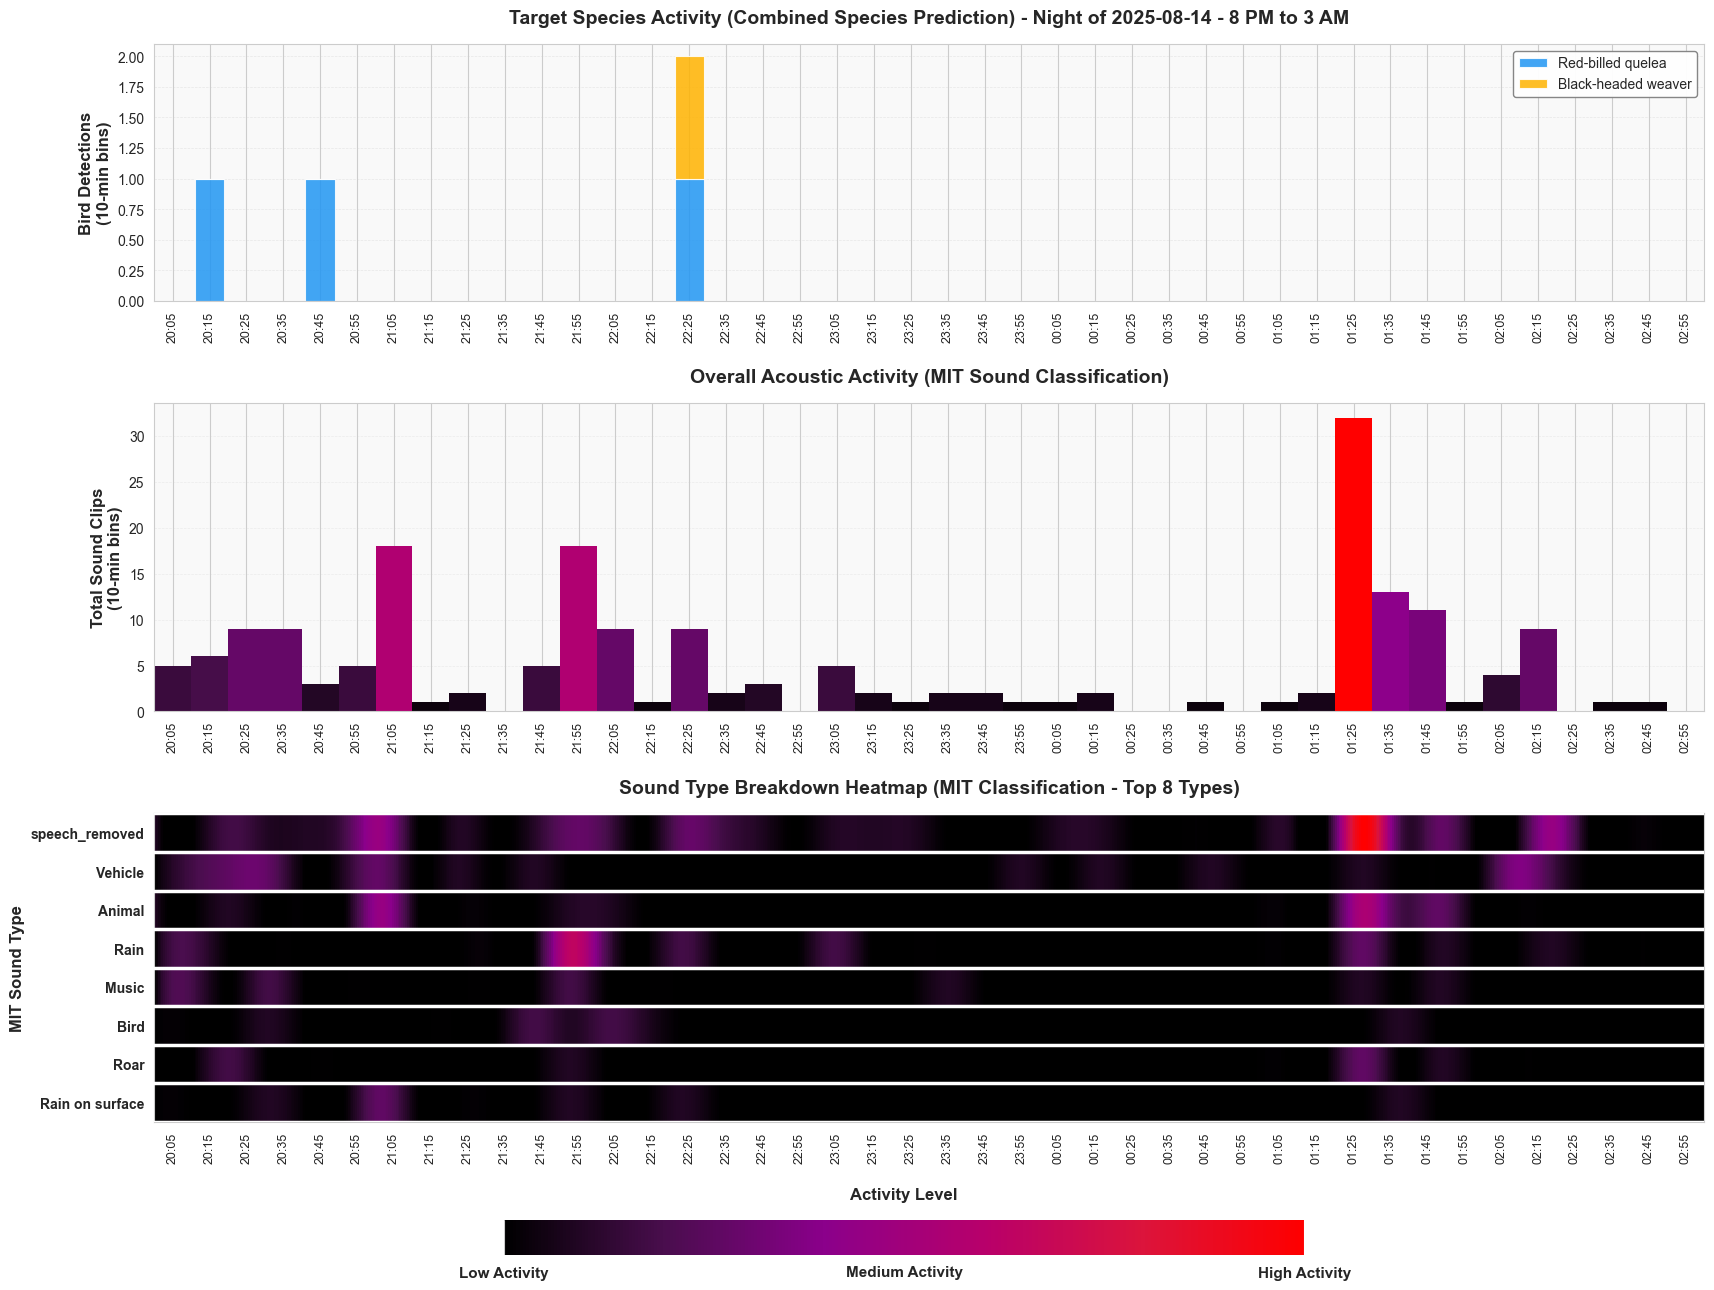

  Total bird detections: 4
  Total sound clips: 197
  Peak bird activity hour: 20:00
  Top 5 sound types:
    1. speech_removed: 52 clips (26.4%)
    2. Vehicle: 24 clips (12.2%)
    3. Animal: 20 clips (10.2%)
    4. Rain: 20 clips (10.2%)
    5. Music: 9 clips (4.6%)
  Species breakdown:
    Red-billed quelea: 3 detections (75.0%)
    Black-headed weaver: 1 detections (25.0%)


In [58]:
# Create per-night activity visualizations with enhanced details
for night in nights_with_birds:
    print(f"\nNight: {night}")
    
    # Define nighttime window for this specific night
    # From 8 PM on the date to 3 AM next morning
    night_start = pd.Timestamp(f"{night} 20:00:00")
    night_end = pd.Timestamp(f"{night}") + timedelta(days=1, hours=3)
    
    # Get bird detections for this night
    night_bird_data = df_night[df_night['night_date'] == night].copy()
    night_bird_data = night_bird_data.sort_values('datetime')
    
    # Get all sound activity for this night from full dataset
    night_full_data = df_full_clean[
        (df_full_clean['datetime'] >= night_start) &
        (df_full_clean['datetime'] <= night_end)
    ].copy()
    
    # Create time bins (10-minute intervals for clear visualization)
    time_bins = pd.date_range(start=night_start, end=night_end, freq='10min')
    
    # Count bird detections per species per bin
    bird_activity = {}
    for species in night_bird_data['detected_species'].unique():
        species_data = night_bird_data[night_bird_data['detected_species'] == species]
        counts, _ = np.histogram(species_data['datetime'], bins=time_bins)
        bird_activity[species] = counts
    
    # Count overall sound activity per bin
    overall_counts, _ = np.histogram(night_full_data['datetime'], bins=time_bins)
    
    # Get MIT classification breakdown per bin
    mit_categories = {}
    for i in range(len(time_bins)-1):
        bin_start = time_bins[i]
        bin_end = time_bins[i+1]
        bin_data = night_full_data[
            (night_full_data['datetime'] >= bin_start) & 
            (night_full_data['datetime'] < bin_end)
        ]
        mit_categories[i] = bin_data['MIT_AST_label'].value_counts().to_dict()
    
    # Create custom colormap: black -> purple -> red
    from matplotlib.colors import LinearSegmentedColormap
    colors_list = ['#000000', '#4a0e4e', '#8b008b', '#b8006b', '#dc143c', '#ff0000']
    n_bins = 256
    cmap_custom = LinearSegmentedColormap.from_list('black_purple_red', colors_list, N=n_bins)
    
    # Create visualization with 3 subplots
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1.2, 1.2], hspace=0.35)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    
    # Plot 1: Bird species activity with enhanced styling
    bin_centers = time_bins[:-1] + (time_bins[1] - time_bins[0]) / 2
    x_positions = np.arange(len(bin_centers))
    
    bottom = np.zeros(len(bin_centers))
    for species, counts in bird_activity.items():
        ax1.bar(x_positions, counts, bottom=bottom, 
                label=SPECIES_INFO[species]['common'],
                color=SPECIES_INFO[species]['color'], 
                alpha=0.85, edgecolor='white', linewidth=0.8)
        bottom += counts
    
    ax1.set_ylabel('Bird Detections\n(10-min bins)', fontweight='bold', fontsize=12)
    ax1.set_title(f'Target Species Activity (Combined Species Prediction) - Night of {night} - 8 PM to 3 AM', 
                  fontweight='bold', fontsize=14, pad=15)
    ax1.legend(loc='upper right', framealpha=0.95, edgecolor='gray', fontsize=10)
    ax1.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.5)
    ax1.set_ylim(bottom=0)
    ax1.set_facecolor('#f9f9f9')
    
    # Format x-axis for ax1 with vertical labels
    time_labels = []
    for i, bc in enumerate(bin_centers):
        time_labels.append(bc.strftime('%H:%M'))
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(time_labels, rotation=90, ha='center', fontsize=9)
    
    # Plot 2: Overall sound activity with black-purple-red gradient
    max_count = max(overall_counts) if max(overall_counts) > 0 else 1
    bars = ax2.bar(x_positions, overall_counts, width=1.0, edgecolor='none')
    
    # Apply custom colormap based on intensity
    for i, (bar, count) in enumerate(zip(bars, overall_counts)):
        intensity = count / max_count
        bar.set_facecolor(cmap_custom(intensity))
    
    ax2.set_ylabel('Total Sound Clips\n(10-min bins)', fontweight='bold', fontsize=12)
    ax2.set_title('Overall Acoustic Activity (MIT Sound Classification)', fontweight='bold', fontsize=14, pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax2.set_ylim(bottom=0)
    ax2.set_facecolor('#f9f9f9')
    ax2.set_xlim(-0.5, len(bin_centers) - 0.5)
    
    # Format x-axis for ax2 with vertical labels
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(time_labels, rotation=90, ha='center', fontsize=9)
    
    # Plot 3: MIT classifications heatmap (row-based with smooth horizontal transitions)
    # Get top 8 most common MIT classifications for this night
    top_mit = night_full_data['MIT_AST_label'].value_counts().head(8).index.tolist()
    
    # Create matrix for heatmap (rows = MIT types, columns = time bins)
    mit_matrix = np.zeros((len(top_mit), len(bin_centers)))
    for i in range(len(bin_centers)):
        if i in mit_categories:
            for j, mit_label in enumerate(top_mit):
                mit_matrix[j, i] = mit_categories[i].get(mit_label, 0)
    
    # Normalize based on overall maximum across all MIT types and time bins
    # This makes the coloring consistent with the overall acoustic activity chart
    mit_matrix_normalized = np.zeros_like(mit_matrix)
    global_max = mit_matrix.max()
    if global_max > 0:
        mit_matrix_normalized = mit_matrix / global_max
    else:
        mit_matrix_normalized = mit_matrix
    
    # Create high-resolution horizontal gradient WITHOUT any vertical bleeding
    # Process each row independently using 1D interpolation
    from scipy.interpolate import interp1d
    
    # Create high-resolution output matrix
    n_bins_highres = len(bin_centers) * 20  # 20x horizontal resolution
    mit_matrix_smooth = np.zeros((len(top_mit), n_bins_highres))
    
    # Interpolate each row independently (no vertical mixing)
    x_original = np.arange(len(bin_centers))
    x_highres = np.linspace(0, len(bin_centers) - 1, n_bins_highres)
    
    for row_idx in range(len(top_mit)):
        # Use cubic interpolation for smooth horizontal gradient
        interpolator = interp1d(x_original, mit_matrix_normalized[row_idx, :], 
                               kind='cubic', fill_value='extrapolate')
        mit_matrix_smooth[row_idx, :] = interpolator(x_highres)
        # Clip to valid range [0, 1]
        mit_matrix_smooth[row_idx, :] = np.clip(mit_matrix_smooth[row_idx, :], 0, 1)
    
    # Display heatmap with 'nearest' to prevent any vertical interpolation
    im = ax3.imshow(mit_matrix_smooth, aspect='auto', cmap=cmap_custom, 
                    interpolation='nearest', extent=[-0.5, len(bin_centers)-0.5, len(top_mit), 0])
    
    # Set y-ticks at row centers with clear labels
    ax3.set_yticks(np.arange(len(top_mit)) + 0.5)
    ax3.set_yticklabels(top_mit, fontsize=10, fontweight='bold')
    ax3.set_ylabel('MIT Sound Type', fontweight='bold', fontsize=12)
    ax3.set_title('Sound Type Breakdown Heatmap (MIT Classification - Top 8 Types)', 
                  fontweight='bold', fontsize=14, pad=15)
    
    # Add clear horizontal dividing lines between MIT sound type rows only
    for i in range(len(top_mit) + 1):
        ax3.axhline(y=i, color='white', linewidth=2.5, zorder=10)
    
    # Remove all grid lines
    ax3.grid(False)
    ax3.set_facecolor('#f9f9f9')
    ax3.set_xlim(-0.5, len(bin_centers) - 0.5)
    
    # Format x-axis: 8 PM to 3 AM with 10-minute intervals (vertical labels)
    ax3.set_xticks(x_positions)
    ax3.set_xticklabels(time_labels, rotation=90, ha='center', fontsize=9)
    
    # Add vertical line at midnight on all plots
    midnight_idx = None
    for i, bc in enumerate(bin_centers):
        if bc.hour == 0 and bc.minute == 0:
            midnight_idx = i
            break
    
    if midnight_idx is not None:
        for ax in [ax1, ax2, ax3]:
            ax.axvline(x=midnight_idx, color='yellow', linestyle='--', 
                      linewidth=2, alpha=0.7, zorder=10)
        ax1.text(midnight_idx, ax1.get_ylim()[1]*0.95, 'Midnight', 
                ha='center', va='top', color='red', fontweight='bold', fontsize=10)
    
    # Create modern activity level legend at the bottom
    legend_ax = fig.add_axes([0.3, 0.015, 0.4, 0.025])
    
    # Create gradient for legend
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    legend_ax.imshow(gradient, aspect='auto', cmap=cmap_custom, extent=[0, 1, 0, 1])
    
    # Style the legend
    legend_ax.set_xlim(0, 1)
    legend_ax.set_ylim(0, 1)
    legend_ax.set_xticks([0, 1])
    legend_ax.set_xticklabels(['Low Activity', 'High Activity'], 
                               fontsize=11, fontweight='bold')
    legend_ax.set_yticks([])
    legend_ax.tick_params(axis='x', length=0, pad=8)
    
    # Add middle label separately without a tick mark
    legend_ax.text(0.5, -0.3, 'Medium Activity', ha='center', va='top', 
                   fontsize=11, fontweight='bold', transform=legend_ax.transData)
    
    # Remove all borders
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    
    # Add title above gradient
    legend_ax.text(0.5, 1.5, 'Activity Level', ha='center', va='bottom', 
                   fontsize=12, fontweight='bold', transform=legend_ax.transAxes)
    
    plt.tight_layout(rect=[0, 0.055, 1, 1])
    plt.show()
    
    # Print summary statistics
    print(f"  Total bird detections: {len(night_bird_data)}")
    print(f"  Total sound clips: {len(night_full_data)}")
    if len(night_bird_data) > 0:
        print(f"  Peak bird activity hour: {night_bird_data['datetime'].dt.hour.mode().values[0]}:00")
    
    print(f"  Top 5 sound types:")
    top_5_mit = night_full_data['MIT_AST_label'].value_counts().head(5)
    for idx, (label, count) in enumerate(top_5_mit.items(), 1):
        pct = (count / len(night_full_data)) * 100
        print(f"    {idx}. {label}: {count} clips ({pct:.1f}%)")
    
    print(f"  Species breakdown:")
    for species in night_bird_data['detected_species'].unique():
        species_count = len(night_bird_data[night_bird_data['detected_species'] == species])
        species_pct = (species_count / len(night_bird_data)) * 100
        print(f"    {SPECIES_INFO[species]['common']}: {species_count} detections ({species_pct:.1f}%)")